In [8]:
from __future__ import print_function, division, absolute_import
from future import standard_library
standard_library.install_aliases()

%matplotlib inline

# External
import numpy as np
# ODL
from odl import (Interval, Rectangle, FunctionSpace,
                 uniform_sampling, uniform_discr)
from odl.util.testutils import all_equal, is_subdict
# TomODL
from odltomo import ASTRA_AVAILABLE
from odltomo import (Parallel2dGeometry, FanFlatGeometry)
from odltomo.backends.astra_cpu import (astra_cpu_forward_projector_call,
                                        astra_cpu_backward_projector_call)
from odltomo.util.testutils import skip_if_no_astra

In [9]:
# DiscreteLp element
vol_space = FunctionSpace(Rectangle([-1, -1.1], [1, 1.1]))
nvoxels = (50, 55)
discr_vol_space = uniform_discr(vol_space, nvoxels, dtype='float32')
discr_data = discr_vol_space.element(1)

In [10]:
# motion and detector parameters, and geometry
angle_offset = 0
angle_intvl = Interval(0, 2 * np.pi)
angle_grid = uniform_sampling(angle_intvl, 36, as_midp=False)
dparams = Interval(-2, 2)
det_grid = uniform_sampling(dparams, 40)
geom_p2d = Parallel2dGeometry(angle_intvl, dparams, angle_grid, det_grid)
src_rad = 1000
det_rad = 100
geom_ff = FanFlatGeometry(angle_intvl, dparams, src_rad, det_rad,
                              angle_grid, det_grid, angle_offset)

In [11]:
# DiscreteLp
ind = 1
proj_rect = angle_intvl.insert(dparams, ind)
proj_space = FunctionSpace(proj_rect)
# TODO: question: intervals have default index, grids not
npixels = angle_grid.insert(det_grid, ind).shape
discr_proj_space = uniform_discr(proj_space, npixels, dtype='float32')

In [12]:
print('\n\n angle interval:', angle_intvl, '\n det params:', dparams, 
      '\n proj rectangle:', proj_rect) 
print(' vol data:', discr_data.shape, np.min(discr_data), np.max(
    discr_data), np.mean(discr_data), discr_vol_space.interp)

save_dir = '/home/jmoosmann/Documents/astra_odl/forward/'

# PARALLEL 2D: forward
proj_data = astra_cpu_forward_projector_call(discr_data, geom_p2d, discr_proj_space)
print(' p2d proj:', proj_data.shape, np.min(proj_data), np.max(
proj_data), np.mean(proj_data), discr_proj_space.interp)



 angle interval: [0.0, 6.28318530718] 
 det params: [-2.0, 2.0] 
 proj rectangle: [0.0, 6.28318530718] x [-2.0, 2.0]
 vol data: (50, 55) 1.0 1.0 1.0 nearest
 p2d proj: (36, 40) 0.0 2.87967038155 1.08853 nearest


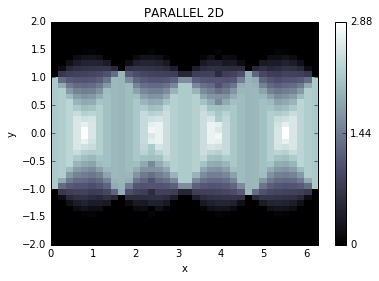

In [13]:
proj_data.show('imshow', saveto=save_dir+'parallel2d_cpu.png', title='PARALLEL 2D')

In [14]:
# PARALLEL 2D: backward
# reco_data = astra_cpu_backward_projector_call(proj_data, geom_p2d,
#                                               discr_vol_space)

# FANFLAT: forward
proj_data = astra_cpu_forward_projector_call(discr_data, geom_ff, discr_proj_space)